# Chapter 11: GANs - MINST

In [31]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
%cd /content/drive/MyDrive/LDS8_K275_ONLINE_NGUYENTHIKIMHOANG/Week_5/Chapter11

/content/drive/MyDrive/LDS8_K275_ONLINE_NGUYENTHIKIMHOANG/Week_5/Chapter11


In [33]:
# pip install tqdm
import numpy as np
from tqdm import tqdm #tạo thanh trượt loading lúc hiển thị kết quả (tạo bảng dễ coi)
import matplotlib.pyplot as plt

In [34]:
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Flatten, LeakyReLU
from tensorflow.keras.layers import Convolution2D, UpSampling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import initializers

In [35]:
# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)
# The results are a little better when the dimensionality of the random vector is
# The dimensionality has been left at 100 for consistency with other GAN implemen
random_dim = 100

In [36]:
# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5 #nếu là 255 thì giải gtri đi từ 0-1, ở đây giải gtri đi từ -1đến 1, phục vụ activation tanh hoặc leakyRelu
X_train = X_train.reshape(60000, 784)

In [37]:
# viet lai duoi dang function doc du lieu
def load_minst_data():
 # load the data
 (x_train, y_train), (x_test, y_test) = mnist.load_data()
 # normalize our inputs to be in the range[-1, 1]
 x_train = (x_train.astype(np.float32) - 127.5)/127.5
 # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
 # 784 columns per row
 x_train = x_train.reshape(60000, 784)
 return (x_train, y_train, x_test, y_test)


In [38]:
# You will use the Adam optimizer
def get_optimizer():
 return Adam(lr=0.0002, beta_1=0.5)

In [39]:
def get_generator(optimizer): #ko add dropout
 generator = Sequential()
 generator.add(Dense(256, 
                     input_dim=random_dim, 
                     kernel_initializer=initializers.RandomNormal(stddev=0.02)))
 generator.add(LeakyReLU(0.2)) #https://en.wikipedia.org/wiki/Rectifier_(neura
 
 generator.add(Dense(512))
 generator.add(LeakyReLU(0.2))
 
 generator.add(Dense(1024))
 generator.add(LeakyReLU(0.2))
 
 generator.add(Dense(784, activation='tanh'))
 generator.compile(loss='binary_crossentropy', optimizer=optimizer)
 return generator


In [40]:
def get_discriminator(optimizer): # có thể add dropout
 discriminator = Sequential()
 discriminator.add(Dense(1024, 
                   input_dim=784, 
                   kernel_initializer=initializers.RandomNormal(stddev=0.02)))
 
 discriminator.add(LeakyReLU(0.2))
 discriminator.add(Dropout(0.3))
 
 discriminator.add(Dense(512))
 discriminator.add(LeakyReLU(0.2))
 discriminator.add(Dropout(0.3))
 
 discriminator.add(Dense(256))
 discriminator.add(LeakyReLU(0.2))
 discriminator.add(Dropout(0.3))
 
 discriminator.add(Dense(1, activation='sigmoid'))
 discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
 return discriminator

In [41]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
 # We initially set trainable to False 
 # since we only want to train either the generator or discriminator at a time
 discriminator.trainable = False
 # gan input (noise) will be 100-dimensional vectors
 gan_input = Input(shape=(random_dim,)) 
 # the output of the generator (an image)
 x = generator(gan_input)
 # get the output of the discriminator (probability if the image is real or no
 gan_output = discriminator(x)
 gan = Model(inputs=gan_input, outputs=gan_output)
 gan.compile(loss='binary_crossentropy', optimizer=optimizer)
 return gan

In [50]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10,10)):
  noise = np.random.normal(0, 1, size=[examples, random_dim]) #random dim=100
  generated_images = generator.predict(noise)
  generated_images = generated_images.reshape(examples, 28, 28)
 
  plt.figure(figsize=figsize)
  for i in range(generated_images.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
    plt.axis('off') 
    plt.tight_layout()
    plt.savefig('mnist/gan_generated_image_epoch_%d.png' % epoch)

In [53]:
def train(epochs=1, batch_size=128):
  # Get the training and testing data
  x_train, y_train, x_test, y_test = load_minst_data()
  # Split the training data into batches of size 128
  batch_count = x_train.shape[0] / batch_size

  # Build our GAN netowrk
  adam = get_optimizer()
  generator = get_generator(adam)
  discriminator = get_discriminator(adam)
  gan = get_gan_network(discriminator, random_dim, generator, adam)

  for e in range(1, epochs+1):
    print('-'*15, 'Epoch %d' % e, '-'*15)
    # tao thanh process bar: https://tqdm.github.io/
    for _ in tqdm(range(int(batch_count))): 
      # Get a random set of input noise and images
      noise = np.random.normal(0, 1, size=[batch_size, random_dim])
      image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

      # Generate fake MNIST images
      generated_images = generator.predict(noise)
      X = np.concatenate([image_batch, generated_images])

      # Labels for generated and real data
      y_dis = np.zeros(2*batch_size)

      # One-sided label smoothing
      y_dis[:batch_size] = 0.9

      # Train discriminator
      discriminator.trainable = True
      discriminator.train_on_batch(X, y_dis)

      # Train generator
      noise = np.random.normal(0, 1, size=[batch_size, random_dim])
      y_gen = np.ones(batch_size)
      discriminator.trainable = False
      gan.train_on_batch(noise, y_gen)

    if e == 1 or e % 20 == 0:
      plot_generated_images(e, generator)
# in ket qua ra file: # save_generated_images(e, generator)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


--------------- Epoch 1 ---------------


100%|██████████| 468/468 [01:36<00:00,  4.86it/s]


--------------- Epoch 2 ---------------


100%|██████████| 468/468 [01:38<00:00,  4.76it/s]


--------------- Epoch 3 ---------------


100%|██████████| 468/468 [01:35<00:00,  4.89it/s]


--------------- Epoch 4 ---------------


100%|██████████| 468/468 [01:35<00:00,  4.89it/s]


--------------- Epoch 5 ---------------


100%|██████████| 468/468 [01:35<00:00,  4.91it/s]


--------------- Epoch 6 ---------------


100%|██████████| 468/468 [01:34<00:00,  4.98it/s]


--------------- Epoch 7 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.09it/s]


--------------- Epoch 8 ---------------


100%|██████████| 468/468 [01:33<00:00,  4.98it/s]


--------------- Epoch 9 ---------------


100%|██████████| 468/468 [01:33<00:00,  4.99it/s]


--------------- Epoch 10 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.16it/s]


--------------- Epoch 11 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.20it/s]


--------------- Epoch 12 ---------------


100%|██████████| 468/468 [01:33<00:00,  5.01it/s]


--------------- Epoch 13 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.08it/s]


--------------- Epoch 14 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.09it/s]


--------------- Epoch 15 ---------------


100%|██████████| 468/468 [01:33<00:00,  4.99it/s]


--------------- Epoch 16 ---------------


100%|██████████| 468/468 [01:34<00:00,  4.98it/s]


--------------- Epoch 17 ---------------


100%|██████████| 468/468 [01:33<00:00,  5.00it/s]


--------------- Epoch 18 ---------------


100%|██████████| 468/468 [01:37<00:00,  4.81it/s]


--------------- Epoch 19 ---------------


100%|██████████| 468/468 [01:34<00:00,  4.93it/s]


--------------- Epoch 20 ---------------


100%|██████████| 468/468 [01:33<00:00,  5.02it/s]


--------------- Epoch 21 ---------------


100%|██████████| 468/468 [01:34<00:00,  4.93it/s]


--------------- Epoch 22 ---------------


100%|██████████| 468/468 [01:33<00:00,  4.99it/s]


--------------- Epoch 23 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.03it/s]


--------------- Epoch 24 ---------------


100%|██████████| 468/468 [01:34<00:00,  4.94it/s]


--------------- Epoch 25 ---------------


100%|██████████| 468/468 [01:33<00:00,  4.98it/s]


--------------- Epoch 26 ---------------


100%|██████████| 468/468 [01:33<00:00,  4.99it/s]


--------------- Epoch 27 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.04it/s]


--------------- Epoch 28 ---------------


100%|██████████| 468/468 [01:34<00:00,  4.93it/s]


--------------- Epoch 29 ---------------


100%|██████████| 468/468 [01:36<00:00,  4.87it/s]


--------------- Epoch 30 ---------------


100%|██████████| 468/468 [01:34<00:00,  4.95it/s]


--------------- Epoch 31 ---------------


100%|██████████| 468/468 [01:33<00:00,  5.00it/s]


--------------- Epoch 32 ---------------


100%|██████████| 468/468 [01:36<00:00,  4.84it/s]


--------------- Epoch 33 ---------------


100%|██████████| 468/468 [01:37<00:00,  4.81it/s]


--------------- Epoch 34 ---------------


100%|██████████| 468/468 [01:36<00:00,  4.86it/s]


--------------- Epoch 35 ---------------


100%|██████████| 468/468 [01:35<00:00,  4.91it/s]


--------------- Epoch 36 ---------------


100%|██████████| 468/468 [01:37<00:00,  4.80it/s]


--------------- Epoch 37 ---------------


100%|██████████| 468/468 [01:34<00:00,  4.94it/s]


--------------- Epoch 38 ---------------


100%|██████████| 468/468 [01:36<00:00,  4.87it/s]


--------------- Epoch 39 ---------------


100%|██████████| 468/468 [01:33<00:00,  4.99it/s]


--------------- Epoch 40 ---------------


100%|██████████| 468/468 [01:35<00:00,  4.88it/s]


--------------- Epoch 41 ---------------


100%|██████████| 468/468 [01:37<00:00,  4.80it/s]


--------------- Epoch 42 ---------------


100%|██████████| 468/468 [01:36<00:00,  4.86it/s]


--------------- Epoch 43 ---------------


100%|██████████| 468/468 [01:35<00:00,  4.88it/s]


--------------- Epoch 44 ---------------


100%|██████████| 468/468 [01:39<00:00,  4.71it/s]


--------------- Epoch 45 ---------------


100%|██████████| 468/468 [01:36<00:00,  4.83it/s]


--------------- Epoch 46 ---------------


100%|██████████| 468/468 [01:35<00:00,  4.92it/s]


--------------- Epoch 47 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.03it/s]


--------------- Epoch 48 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.13it/s]


--------------- Epoch 49 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.10it/s]


--------------- Epoch 50 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.09it/s]


--------------- Epoch 51 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.17it/s]


--------------- Epoch 52 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.17it/s]


--------------- Epoch 53 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.10it/s]


--------------- Epoch 54 ---------------


100%|██████████| 468/468 [01:33<00:00,  4.99it/s]


--------------- Epoch 55 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.09it/s]


--------------- Epoch 56 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.06it/s]


--------------- Epoch 57 ---------------


100%|██████████| 468/468 [01:33<00:00,  4.98it/s]


--------------- Epoch 58 ---------------


100%|██████████| 468/468 [01:33<00:00,  5.03it/s]


--------------- Epoch 59 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.06it/s]


--------------- Epoch 60 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.07it/s]


--------------- Epoch 61 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.20it/s]


--------------- Epoch 62 ---------------


100%|██████████| 468/468 [01:28<00:00,  5.30it/s]


--------------- Epoch 63 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.05it/s]


--------------- Epoch 64 ---------------


100%|██████████| 468/468 [01:29<00:00,  5.22it/s]


--------------- Epoch 65 ---------------


100%|██████████| 468/468 [01:28<00:00,  5.28it/s]


--------------- Epoch 66 ---------------


100%|██████████| 468/468 [01:29<00:00,  5.25it/s]


--------------- Epoch 67 ---------------


100%|██████████| 468/468 [01:29<00:00,  5.25it/s]


--------------- Epoch 68 ---------------


100%|██████████| 468/468 [01:29<00:00,  5.25it/s]


--------------- Epoch 69 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.06it/s]


--------------- Epoch 70 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.12it/s]


--------------- Epoch 71 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.18it/s]


--------------- Epoch 72 ---------------


100%|██████████| 468/468 [01:29<00:00,  5.21it/s]


--------------- Epoch 73 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.19it/s]


--------------- Epoch 74 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.05it/s]


--------------- Epoch 75 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.17it/s]


--------------- Epoch 76 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.16it/s]


--------------- Epoch 77 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.13it/s]


--------------- Epoch 78 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.19it/s]


--------------- Epoch 79 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.11it/s]


--------------- Epoch 80 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.10it/s]


--------------- Epoch 81 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.10it/s]


--------------- Epoch 82 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.18it/s]


--------------- Epoch 83 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.09it/s]


--------------- Epoch 84 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.19it/s]


--------------- Epoch 85 ---------------


100%|██████████| 468/468 [01:29<00:00,  5.20it/s]


--------------- Epoch 86 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.17it/s]


--------------- Epoch 87 ---------------


100%|██████████| 468/468 [01:34<00:00,  4.96it/s]


--------------- Epoch 88 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.15it/s]


--------------- Epoch 89 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.18it/s]


--------------- Epoch 90 ---------------


100%|██████████| 468/468 [01:29<00:00,  5.21it/s]


--------------- Epoch 91 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.20it/s]


--------------- Epoch 92 ---------------


100%|██████████| 468/468 [01:29<00:00,  5.23it/s]


--------------- Epoch 93 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.08it/s]


--------------- Epoch 94 ---------------


100%|██████████| 468/468 [01:29<00:00,  5.21it/s]


--------------- Epoch 95 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.18it/s]


--------------- Epoch 96 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.20it/s]


--------------- Epoch 97 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.18it/s]


--------------- Epoch 98 ---------------


100%|██████████| 468/468 [01:28<00:00,  5.27it/s]


--------------- Epoch 99 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.16it/s]


--------------- Epoch 100 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.16it/s]


--------------- Epoch 101 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.13it/s]


--------------- Epoch 102 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.14it/s]


--------------- Epoch 103 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.06it/s]


--------------- Epoch 104 ---------------


100%|██████████| 468/468 [01:29<00:00,  5.22it/s]


--------------- Epoch 105 ---------------


100%|██████████| 468/468 [01:29<00:00,  5.21it/s]


--------------- Epoch 106 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.14it/s]


--------------- Epoch 107 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.11it/s]


--------------- Epoch 108 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.07it/s]


--------------- Epoch 109 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.06it/s]


--------------- Epoch 110 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.19it/s]


--------------- Epoch 111 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.12it/s]


--------------- Epoch 112 ---------------


100%|██████████| 468/468 [01:33<00:00,  5.02it/s]


--------------- Epoch 113 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.07it/s]


--------------- Epoch 114 ---------------


100%|██████████| 468/468 [01:33<00:00,  4.99it/s]


--------------- Epoch 115 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.09it/s]


--------------- Epoch 116 ---------------


100%|██████████| 468/468 [01:33<00:00,  5.00it/s]


--------------- Epoch 117 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.12it/s]


--------------- Epoch 118 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.08it/s]


--------------- Epoch 119 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.06it/s]


--------------- Epoch 120 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.14it/s]


--------------- Epoch 121 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.07it/s]


--------------- Epoch 122 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.07it/s]


--------------- Epoch 123 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.10it/s]


--------------- Epoch 124 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.07it/s]


--------------- Epoch 125 ---------------


100%|██████████| 468/468 [01:35<00:00,  4.91it/s]


--------------- Epoch 126 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.05it/s]


--------------- Epoch 127 ---------------


100%|██████████| 468/468 [01:33<00:00,  5.03it/s]


--------------- Epoch 128 ---------------


100%|██████████| 468/468 [01:33<00:00,  5.02it/s]


--------------- Epoch 129 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.16it/s]


--------------- Epoch 130 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.19it/s]


--------------- Epoch 131 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.15it/s]


--------------- Epoch 132 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.08it/s]


--------------- Epoch 133 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.11it/s]


--------------- Epoch 134 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.11it/s]


--------------- Epoch 135 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.17it/s]


--------------- Epoch 136 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.18it/s]


--------------- Epoch 137 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.09it/s]


--------------- Epoch 138 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.19it/s]


--------------- Epoch 139 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.11it/s]


--------------- Epoch 140 ---------------


100%|██████████| 468/468 [01:33<00:00,  4.99it/s]


--------------- Epoch 141 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.09it/s]


--------------- Epoch 142 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.10it/s]


--------------- Epoch 143 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.05it/s]


--------------- Epoch 144 ---------------


100%|██████████| 468/468 [01:33<00:00,  4.99it/s]


--------------- Epoch 145 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.10it/s]


--------------- Epoch 146 ---------------


100%|██████████| 468/468 [01:33<00:00,  5.00it/s]


--------------- Epoch 147 ---------------


100%|██████████| 468/468 [01:34<00:00,  4.97it/s]


--------------- Epoch 148 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.04it/s]


--------------- Epoch 149 ---------------


100%|██████████| 468/468 [01:33<00:00,  5.03it/s]


--------------- Epoch 150 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.09it/s]


--------------- Epoch 151 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.09it/s]


--------------- Epoch 152 ---------------


100%|██████████| 468/468 [01:35<00:00,  4.90it/s]


--------------- Epoch 153 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.08it/s]


--------------- Epoch 154 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.04it/s]


--------------- Epoch 155 ---------------


100%|██████████| 468/468 [01:33<00:00,  5.01it/s]


--------------- Epoch 156 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.06it/s]


--------------- Epoch 157 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.04it/s]


--------------- Epoch 158 ---------------


100%|██████████| 468/468 [01:34<00:00,  4.97it/s]


--------------- Epoch 159 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.14it/s]


--------------- Epoch 160 ---------------


100%|██████████| 468/468 [01:34<00:00,  4.96it/s]


--------------- Epoch 161 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.05it/s]


--------------- Epoch 162 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.05it/s]


--------------- Epoch 163 ---------------


100%|██████████| 468/468 [01:34<00:00,  4.96it/s]


--------------- Epoch 164 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.06it/s]


--------------- Epoch 165 ---------------


100%|██████████| 468/468 [01:34<00:00,  4.95it/s]


--------------- Epoch 166 ---------------


100%|██████████| 468/468 [01:34<00:00,  4.98it/s]


--------------- Epoch 167 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.03it/s]


--------------- Epoch 168 ---------------


100%|██████████| 468/468 [01:33<00:00,  4.99it/s]


--------------- Epoch 169 ---------------


100%|██████████| 468/468 [01:33<00:00,  5.02it/s]


--------------- Epoch 170 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.13it/s]


--------------- Epoch 171 ---------------


100%|██████████| 468/468 [01:33<00:00,  5.03it/s]


--------------- Epoch 172 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.15it/s]


--------------- Epoch 173 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.11it/s]


--------------- Epoch 174 ---------------


100%|██████████| 468/468 [01:34<00:00,  4.93it/s]


--------------- Epoch 175 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.12it/s]


--------------- Epoch 176 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.06it/s]


--------------- Epoch 177 ---------------


100%|██████████| 468/468 [01:33<00:00,  5.01it/s]


--------------- Epoch 178 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.09it/s]


--------------- Epoch 179 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.10it/s]


--------------- Epoch 180 ---------------


100%|██████████| 468/468 [01:33<00:00,  5.01it/s]


--------------- Epoch 181 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.09it/s]


--------------- Epoch 182 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.11it/s]


--------------- Epoch 183 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.18it/s]


--------------- Epoch 184 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.15it/s]


--------------- Epoch 185 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.11it/s]


--------------- Epoch 186 ---------------


100%|██████████| 468/468 [01:29<00:00,  5.23it/s]


--------------- Epoch 187 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.11it/s]


--------------- Epoch 188 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.12it/s]


--------------- Epoch 189 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.05it/s]


--------------- Epoch 190 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.13it/s]


--------------- Epoch 191 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.14it/s]


--------------- Epoch 192 ---------------


100%|██████████| 468/468 [01:33<00:00,  5.02it/s]


--------------- Epoch 193 ---------------


100%|██████████| 468/468 [01:35<00:00,  4.90it/s]


--------------- Epoch 194 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.03it/s]


--------------- Epoch 195 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.11it/s]


--------------- Epoch 196 ---------------


100%|██████████| 468/468 [01:34<00:00,  4.98it/s]


--------------- Epoch 197 ---------------


100%|██████████| 468/468 [01:32<00:00,  5.08it/s]


--------------- Epoch 198 ---------------


100%|██████████| 468/468 [01:31<00:00,  5.13it/s]


--------------- Epoch 199 ---------------


100%|██████████| 468/468 [01:30<00:00,  5.16it/s]


--------------- Epoch 200 ---------------


100%|██████████| 468/468 [01:28<00:00,  5.26it/s]


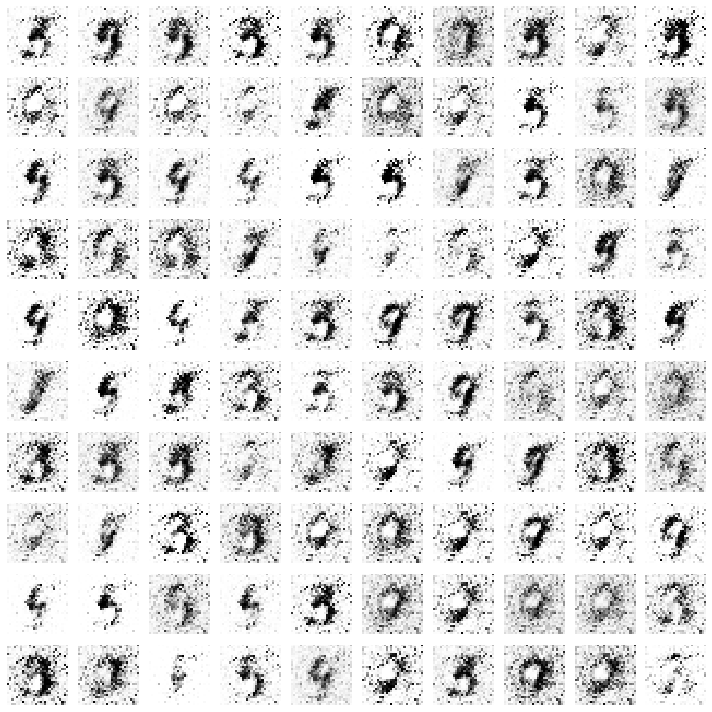

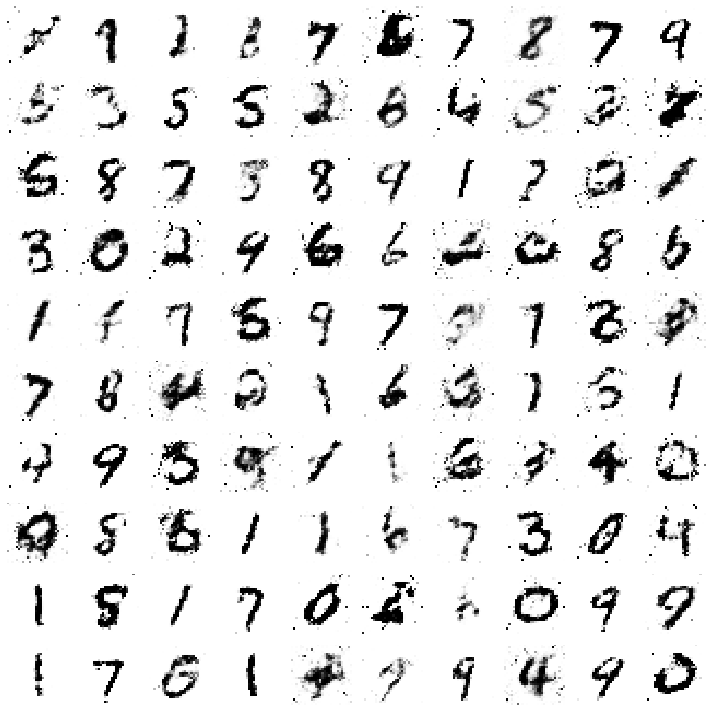

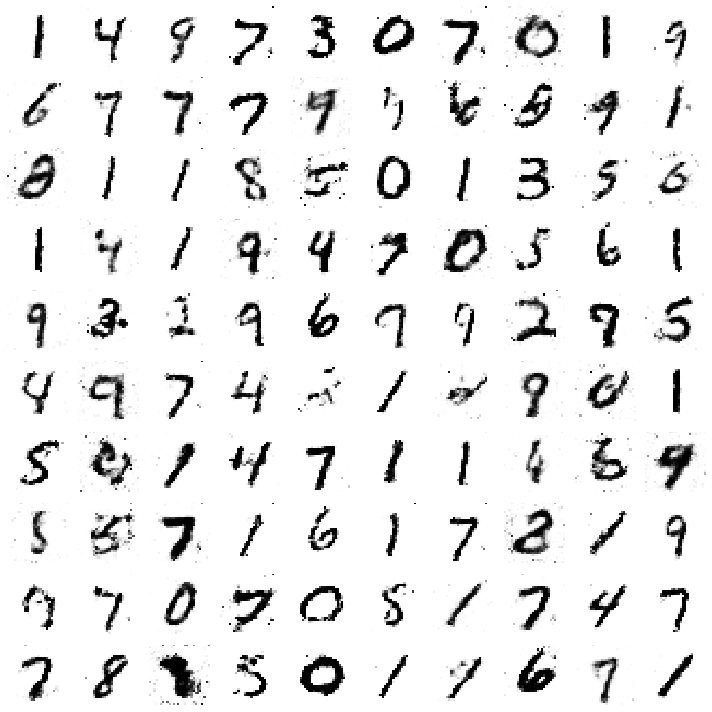

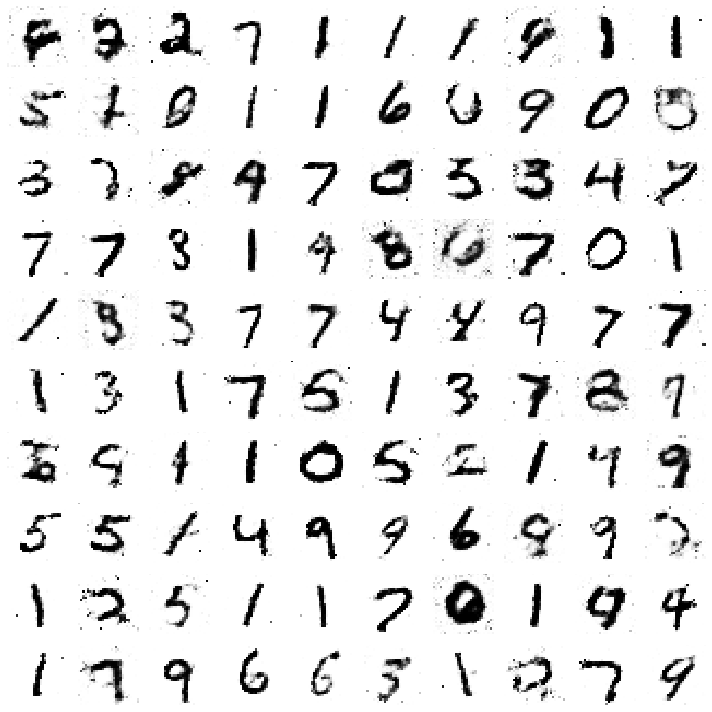

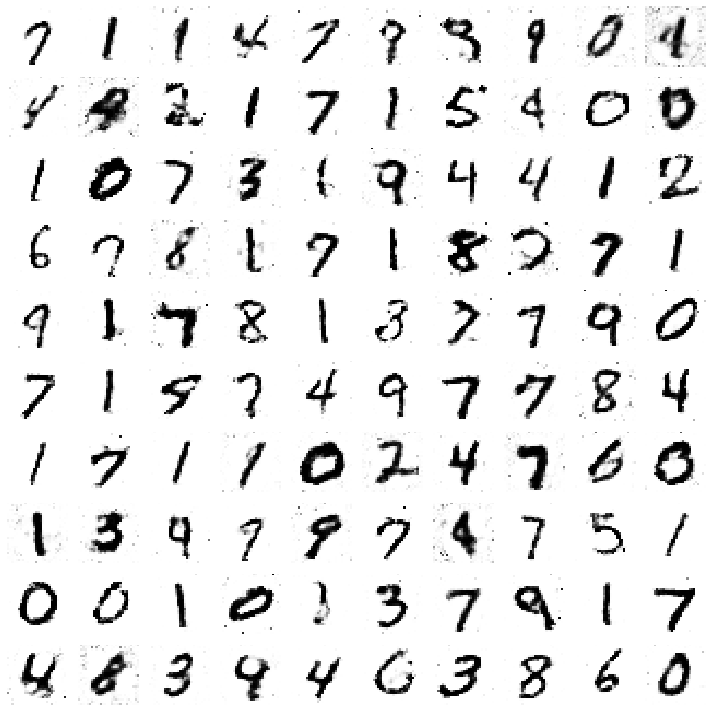

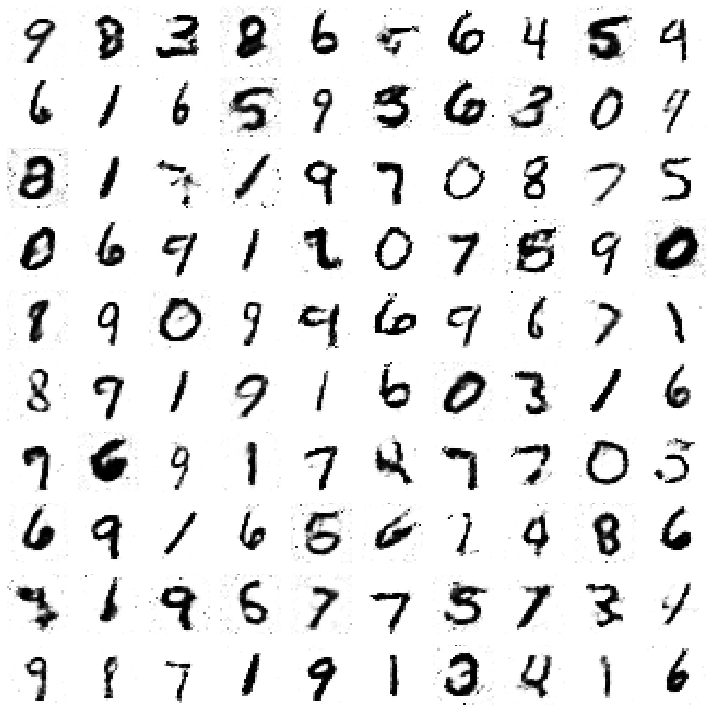

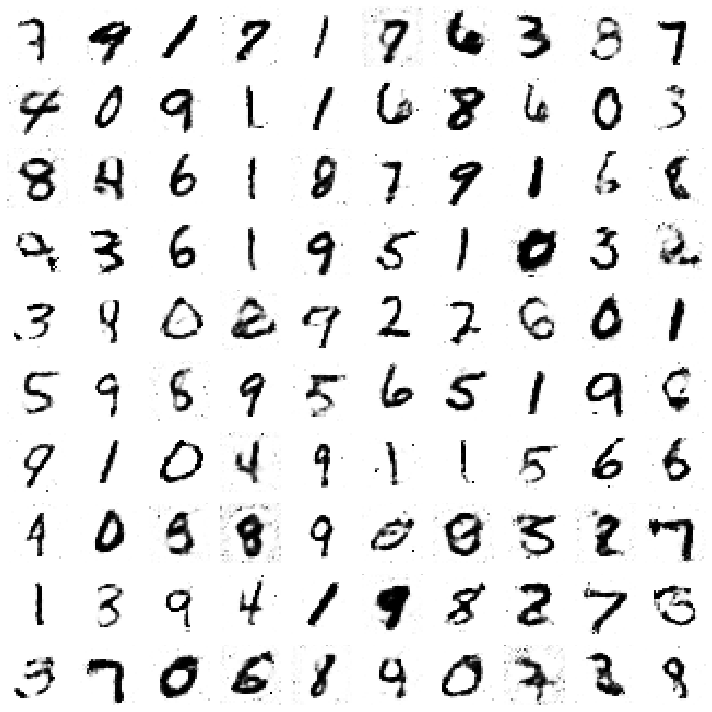

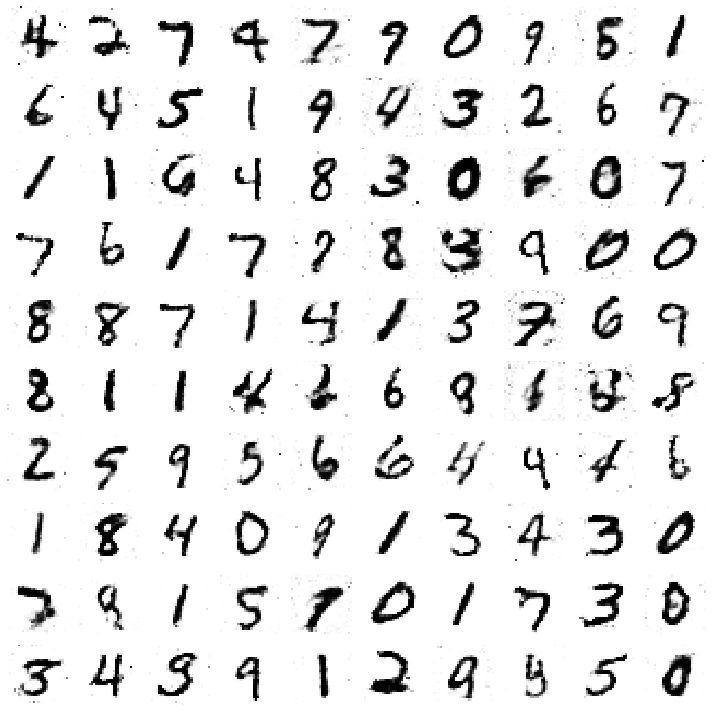

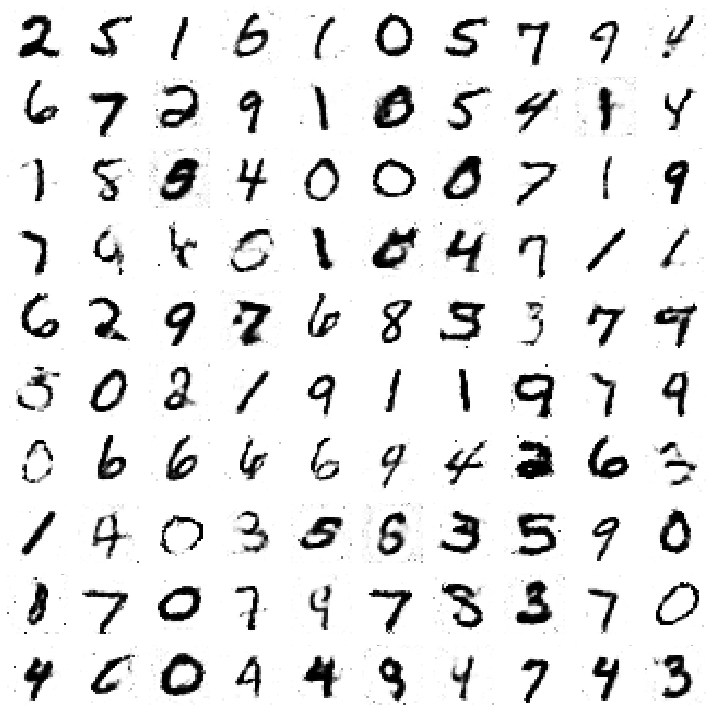

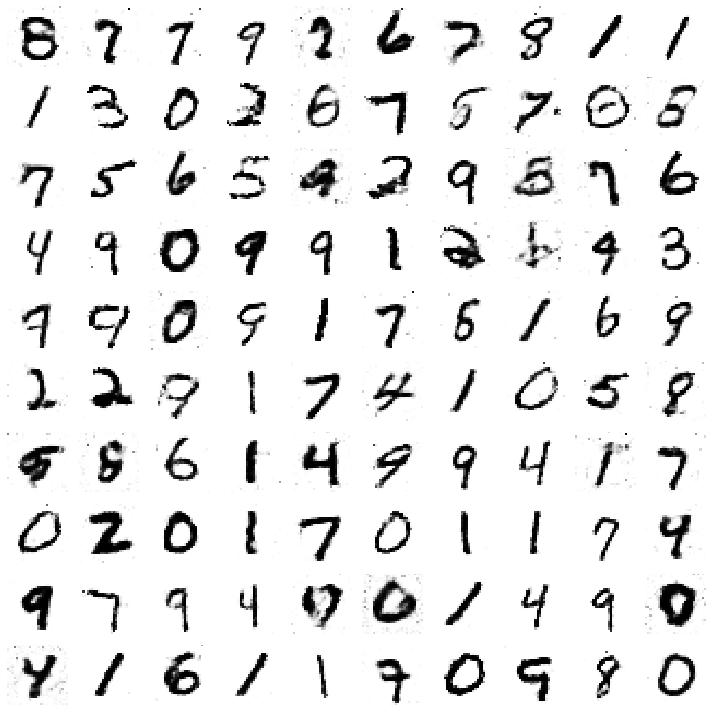

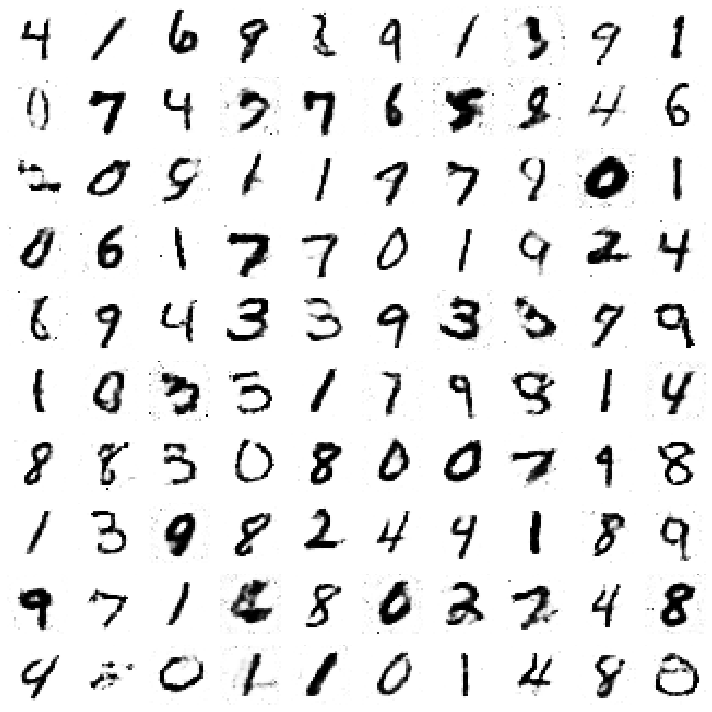

In [ ]:
train(200, 128) # chay epoch = 200, batch = 128

In [ ]:
# In progress bar
from tqdm import tqdm
from time import sleep

In [ ]:
for i in tqdm(range(10000)):
 #...
 pass

In [ ]:
pbar = tqdm(total=100)
for i in range(10):
 sleep(0.1)
 pbar.update(10)
pbar.close()